In [4]:
# import libraries for image processing and array operations
from PIL import Image
from Images import imageToPixmapRGB
from numpy import array, dot, dstack, log, log2, sqrt, transpose, uint8, zeros, where


def loadDataMatrix(fileName, sampleName, default=0.0):
    '''Create a Microarray object from a text file'''
    fileObj = open(fileName, 'r')
  
    rows = set()
    cols = set()
    dataDict = {} # this will be a nested dict of row:column and column:value

    for line in fileObj: # file expected to be formatted as "row column value\n on each line"
        row, col, value = line.split()

        if row not in dataDict: # add new row to dict when a new row appears in file
            dataDict[row] = {}

        if col in dataDict[row]: # if a column already exists in a row, warn of duplicate
            print('Repeat entry found for element %d, %d' % (row, col))
            continue

        dataDict[row][col] = float(value) # assign value to row-column pair
    
        rows.add(row) # add rows and columns to tracker set
        cols.add(col)
  
    rows = sorted(rows)
    cols = sorted(cols)
  
    nRows = len(rows)
    nCols = len(cols)

    dataMatrix = zeros((nRows, nCols), float) # initialize empty matrix

    for i, row in enumerate(rows): # populate the matrix with values by row and column
        for j, col in enumerate(cols):
            value = dataDict[row].get(col, default)
            dataMatrix[i,j] = value
  
    fileObj.close()

    return Microarray(sampleName, dataMatrix, rows, cols)



def loadArrayImage(fileName, sampleName, nRows, nCols=None):
    '''Read image file and return Microarray object, must specify dimensions of array in spots'''
    if not nCols:
        nCols = nRows
  
    dataMatrix = zeros((3, nRows, nCols), float) # initialize matrix
  
    img = Image.open(fileName) # Auto file type
    pixmap = imageToPixmapRGB(img)
  
    height, width, depth = pixmap.shape
  
    dx = width/float(nCols) # width per number of array columns
    dy = height/float(nRows) # length per number of array rows
    xSize = 1 + (width-1)//nCols
    ySize = 1 + (height-1)//nRows

    for row in range(nRows): # Simple conversion from image to array of values,
        yStart = int(row*dy) # Assume spots are evenly spaced, calculate a grid separating spots
        yEnd   = yStart + ySize

        for col in range(nCols):
            xStart = int(col*dx)
            xEnd   = xStart + xSize

            elementData = pixmap[yStart:yEnd,xStart:xEnd] # The spot = all pixels within the grid square
            dataMatrix[:,row, col] = elementData.sum(axis=(0,1)) # sum values within grid to call spot

    img.close()
    return Microarray(sampleName, dataMatrix)


class Microarray(object):
    '''Digital representation of the information contained in the microarray'''
    def __init__(self, name, data, rowData=None, colData=None):
        '''Initialize object attributes based on input data'''
   
        self.name = name 
        data = array(data)

        shape = data.shape
    
        if len(shape) == 3:
            self.nChannels, self.nRows, self.nCols = shape
    
        elif len(shape) == 2:
            self.nRows, self.nCols = shape
            self.nChannels = 1
            data = array([data]) # add an empty dimension to simplify later math

        else:
            raise Exception('Array data must have either 2 or 3 axes.')  

        self.data = data
        self.origData = array(data)
  
        self.rowData = rowData or range(self.nRows)
        self.colData = colData or range(self.nCols)

    def resetData(self):
        
        self.data = array(self.origData)
        self.nChannels = len(self.data)

    def writeData(self, fileName, separator=' '):
        '''Save to disk at fileName as text file of values to 3 decimal places'''
        fileObj = open(fileName, 'w')
    
        for i in range(self.nRows):
            rowName = str(self.rowData[i])
      
            for j in range(self.nCols):
                colName = str(self.colData[j])

                values = self.data[:,i,j]

                lineData = [rowName, colName]
                lineData += ['%.3f' % (v,) for v in values]
        
                line = separator.join(lineData)
                fileObj.write(line + '\n')
                
        fileObj.close()

    def makeImage(self, squareSize=20, channels=None):
        '''Generate an image from the sequence data read'''
        minVal = self.data.min()
        maxVal = self.data.max() 
        dataRange = maxVal - minVal  

        adjData = (self.data - minVal) * 255 / dataRange # Adjust read values to pixel brightness
        adjData = array(adjData, uint8)
   
        if not channels:
            if self.nChannels == 1:
                channels = (0,0,0) # Greyscale
            else:
                channels = list(range(self.nChannels))[:3] # use all channels

        pixmap = []
        for i in channels: # Use only user specified channels
            if i is None: 
                pixmap.append(zeros((self.nRows, self.nCols), uint8))
            else:
                pixmap.append(adjData[i])
        
        while len(pixmap) < 3: # ensure empty channels are populated with zeroes
            pixmap.append(zeros((self.nRows, self.nCols), uint8))
     
        pixmap = dstack(pixmap) # reshape into 2d array of RGB values
        img = Image.fromarray(pixmap, 'RGB')

        width = self.nCols * squareSize
        height = self.nRows * squareSize
        img = img.resize((width, height))
    
        return img

    def clipBaseline(self, threshold=None, channels=None, defaultProp=0.2):
        '''Set values below a certain threshold to zero'''
        if not channels:
            channels = range(self.nChannels)
    
        channels = [tuple(channels)]
    
        maxVal = self.data[channels].max()
        if threshold is None:
            limit = maxVal * defaultProp
        else:
            limit = threshold
    
        boolArray = self.data[channels] < limit
        indices = boolArray[0].nonzero() # BUGFIX somehow this operation adds a fourth dimension, quickfix to repair shape
        
        self.data[indices] = limit

        self.data[channels] -= limit
        self.data[channels] *= maxVal / (maxVal-limit)

    # Several normalization algorithms to allow comparison across arrays and between spots
    
    def normaliseSd(self, scale=1.0): 
        
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].std()


    def normaliseMean(self, scale=1.0):
    
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].mean()


    def centerMean(self):
        '''Center values at zero to allow comparison between arrays'''
        for i in range(self.nChannels):
            self.data[i] -= self.data[i].mean()


    def normaliseZscore(self):
    
        self.centerMean()
        self.normaliseSd()


    def normaliseMax(self, scale=1.0, perChannel=True):
    
        if perChannel:
            for i in range(self.nChannels):
                self.data[i] = self.data[i] * scale / self.data[i].max()
    
        else:
            self.data = self.data * scale / self.data.max()


    def normaliseRowMax(self, scale=1.0):
  
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].max(axis=1)[:,None]


    def normaliseRowMean(self, scale=1.0):
  
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].mean(axis=1)[:,None]


    def normaliseColMax(self, scale=1.0):
  
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].max(axis=0)

    def normaliseColMean(self, scale=1.0):
  
        for i in range(self.nChannels):
            self.data[i] = self.data[i] * scale / self.data[i].mean(axis=0)
    

    def normaliseRefs(self, rows, cols, scale=1.0, channels=None):
  
        if not channels:
            channels = range(self.nChannels)

        channels = tuple(channels)
        refValues = self.data[channels, rows, cols]
    
        for i in channels:
            self.data[i] = self.data[i] * scale / refValues[i].mean()
    

    def normaliseLogMean(self):
        '''Normalize by taking log of mean normalized data, helps'''
        self.clipBaseline(threshold=0.0)
        for i in range(self.nChannels):
            self.data[i] = log( 1.0 + self.data[i] / self.data[i].mean() )


    def normaliseQuantile(self, refData, channel=0):
        # could be to a different channel
    
        values = self.data[channel].flatten()
        order = values.argsort()

        refValues = refData.flatten()
        refValues.sort()

        refSelection = order.argsort()
        values = refValues[refSelection]

        self.data[channel] = values.reshape((self.nRows, self.nCols))

    
    def normaliseRowQuantile(self, channel=0):
    
        channelData = self.data[channel]

        orders = channelData.argsort(axis=1)
        sortedRows = array(channelData)
        sortedRows.sort(axis=1)
        refValues = sortedRows.mean(axis=0) # average over columns

        rows = range(self.nRows)
        self.data[channel,rows,:] = refValues[orders[rows,:].argsort()]


    def checkDataSize(self, channelData, index):
        '''Sanity check on channel data before overwriting any microarray data'''
        channelData = array(channelData)
        
        if channelData.shape != self.data[index].shape:
            # edited--channels are only ever edited by adding or replacing whole rows
            # therefore the only relevant match in length of channel data and nCols
            
            msg = f'Channel shape mismatch new={channelData.shape} existing={self.data.shape}' 
            # edited--make error more informative
            raise Exception(msg)
  
        return channelData

    def setChannel(self, channelData, index=0):
        '''Replace values for one channel'''
        channelData = self.checkDataSize(channelData, index)
        self.data[index] = channelData

    def addChannel(self, channelData):
        '''Add additional channel'''
        from numpy import append
        channelData = self.checkDataSize(channelData)

        self.data = append(self.data, channelData, axis=0)
        self.nChannels += 1

    def swapChannels(self, indexA, indexB):
        '''Change channels, eg red becomes green'''
        self.data[(indexB, indexA)] = self.data[(indexA, indexB)]

    def removeChannel(self, index):
        '''Delete one channel'''
        from numpy import delete     
        if index < self.nChannels:
            self.data = delete(self.data, index, axis=0)

    def combineChannels(self, indexA, indexB, combFunc=None, replace=None):
        '''Combine channels as specified by combFunc--defaults to addition'''
        if not combFunc:
            import operator
            combFunc= operator.add 

        channelData = combFunc(self.data[indexA], self.data[indexB])

        if replace is None:
            self.addChannel(channelData)

        else:
            for i in range(len(channelData)):
                self.setChannel(channelData[i], index=i)

    def __hierarchicalRowCluster(self, dataMatrix):
        '''Generate distance matrix and return the order of rows to use for the clustered data'''
        from SeqVariation import neighbourJoinTree

        n = len(dataMatrix[0])
        distanceMatrix = zeros((n, n), float)
    
        for channelData in dataMatrix:
            for i, row in enumerate(channelData):
                diffs = channelData - row
                sqDiffs = diffs * diffs
                sqDists = sqDiffs.sum(axis=1)
                distanceMatrix[i,:] += sqDists

        tree, joinOrder = neighbourJoinTree(distanceMatrix.tolist())

        rowOrder = list(tree)
  
        i  = 0
        while i < len(rowOrder):

            while not isinstance(rowOrder[i], int):
                rowOrder[i:i+1] = rowOrder[i]

            i += 1

        return rowOrder

    def hierarchicalCluster(self):
        '''Create hierarchically clustered array from self, return modified copy
        Self arrays not changed.'''
        rows = self.__hierarchicalRowCluster(self.data)


        swapped = transpose(self.data, axes=(0,2,1)) # order columns
        cols = self.__hierarchicalRowCluster(swapped)

        data = self.data[:,rows] # Rearrange
        data = data[:,:,cols]

        data = array(data.tolist()) # to fix PIL.Image bug

        name = self.name + '-Sorted'
        rowData = [self.rowData[i] for i in rows]
        colData = [self.colData[j] for j in cols]

        sortedArray = Microarray(name, data, rowData, colData)

        return sortedArray 


# Load image and create array

In [2]:
test_array = loadArrayImage('RedGreenArray.png', 'test_array', nRows=18, nCols=17)
# Spots counted by manually

In [ ]:
test_array.makeImage()

# Combine channels by subtraction

In [ ]:
# Function to combine channels by--subtract green from red, assign pos to red, neg to green

def subtractRedGreen(red, green):
    data = array(red - green)
    boolArray = data > 0
    reverseBoolArray = boolArray != True
    
    red_dif = zeros(red.shape)
    green_dif = zeros(green.shape)
    
    red_dif = where(boolArray, data, red_dif)
    green_dif = where(reverseBoolArray, data, green_dif)
    
    return array([red_dif, green_dif])
    
    

In [ ]:
test_array.combineChannels(0, 1, combFunc = subtractRedGreen, replace=True)

In [ ]:
test_array.makeImage()

# Combine Red and green data with log2 of their ratio

In [ ]:
test_array.resetData()

In [ ]:
log2Ratio = log2(test_array.data[0] / test_array.data[1])

In [ ]:
combined_red = test_array.data[0] + log2Ratio
combined_green = test_array.data[1] + log2Ratio

# Generate Distance matrix for each row in 2D array

In [ ]:
def makeDistMatrix(dataMatrix):

        height = dataMatrix.shape[0]
        width = dataMatrix.shape[1]
        distanceMatrix = zeros((height, width), float)

        for y, row in enumerate(dataMatrix):
            diffs = dataMatrix - row
            sqDiffs = diffs * diffs
            sqDists = sqDiffs.sum(axis=0)
            distanceMatrix[y] += sqDists
            
        for x, col in enumerate(dataMatrix.T):
            diffs = dataMatrix.T - col
            sqDiffs = diffs * diffs
            sqDists = sqDiffs.sum(axis=0) # axis is still 0 because we transposed the matrix
            distanceMatrix.T[x] += sqDists
            
        return distanceMatrix

In [ ]:
makeDistMatrix(test_array.data[0])

# Log Normalize Fluorescence Intensity

In [3]:
test_array.normaliseLogMean()

(1, 3, 18, 17) 
 3


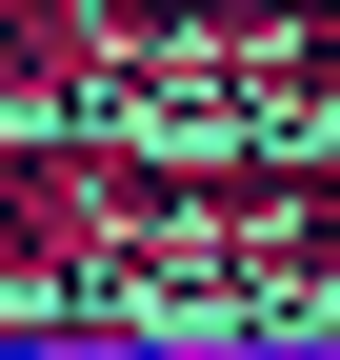

In [5]:
test_array.makeImage() # log normalized image